In [1]:
import os

models = {
    "threshold 0.0": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.31_QED_sillywalks_threshold_1_CNOF/",
    "threshold 1.0 (none)": os.environ["DATA"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks/02.32_QED_sillywalks_threshold_0_CNOF/",
}

sub_experiments_names = [str(i) for i in range(1, 31)]

output_fig_path = os.environ["FIGURES"] + "/03_paper_popalg/01_QED_opt/v3_sillywalks"


In [2]:
import csv
from os.path import join
import numpy as np

def extract_best_scores(model_root, n_scores):
    
    smiles = []
    scores = []
    
    with open(join(model_root, "all_generated.csv"), "r") as f:
        reader = csv.reader(f)

        
        for i, row in enumerate(reader):
            if i > 0 and row[3] != "":
                smiles.append(row[1])
                scores.append(float(row[3]))
                
    sort_mask = np.argsort(scores)[::-1][:n_scores]
    
    return np.array(smiles)[sort_mask], np.array(scores)[sort_mask]
                
    
    

In [3]:
from IPython.display import display, HTML
from rdkit.Chem.Draw import MolsToGridImage, DrawingOptions
from rdkit.Chem import MolFromSmiles
from evomol.evaluation import CLScoreEvaluationStrategy, SAScoreEvaluationStrategy
from evomol.molgraphops.molgraph import MolGraph
from PIL import Image
import io

cl_strat = CLScoreEvaluationStrategy()
sa_strat = SAScoreEvaluationStrategy()

def compute_legend(smi, qed_score):
    
    cl_score = cl_strat.evaluate_individual(MolGraph(MolFromSmiles(smi)))[0]
    sa_score = sa_strat.evaluate_individual(MolGraph(MolFromSmiles(smi)))[0]

    return "{:.3f}".format(qed_score) + " [" + "{:.2f}".format(cl_score) + ", " + "{:.2f}".format(sa_score) + "]"
    
    
def plot_solutions(models):
    
    display(HTML("<h2>" + "QED [CLScore, SAScore]" + "</h2>"))

    for model_name, model_path in models.items():
        
        best_smiles, legends = [], []
        
        display(HTML("<h3>" + model_name + "</h3>"))

        for sub_exp_name in sub_experiments_names:
        
            curr_best_smiles, curr_best_scores = extract_best_scores(join(model_path, sub_exp_name), 1)
            
            best_smiles.extend(curr_best_smiles)
            
            legends.extend([compute_legend(curr_best_smiles[i], curr_best_scores[i]) for i in range(len(curr_best_smiles))])
        
        img = MolsToGridImage([MolFromSmiles(smi) for smi in best_smiles], 
                               legends=legends, molsPerRow=5, subImgSize=(200, 200))
        
        
        buf = io.BytesIO()
        buf.write(img.data)
        buf.seek(0)
        img = Image.open(buf)
        
        img.save(join(output_fig_path, model_name + ".png"))
        display(img)

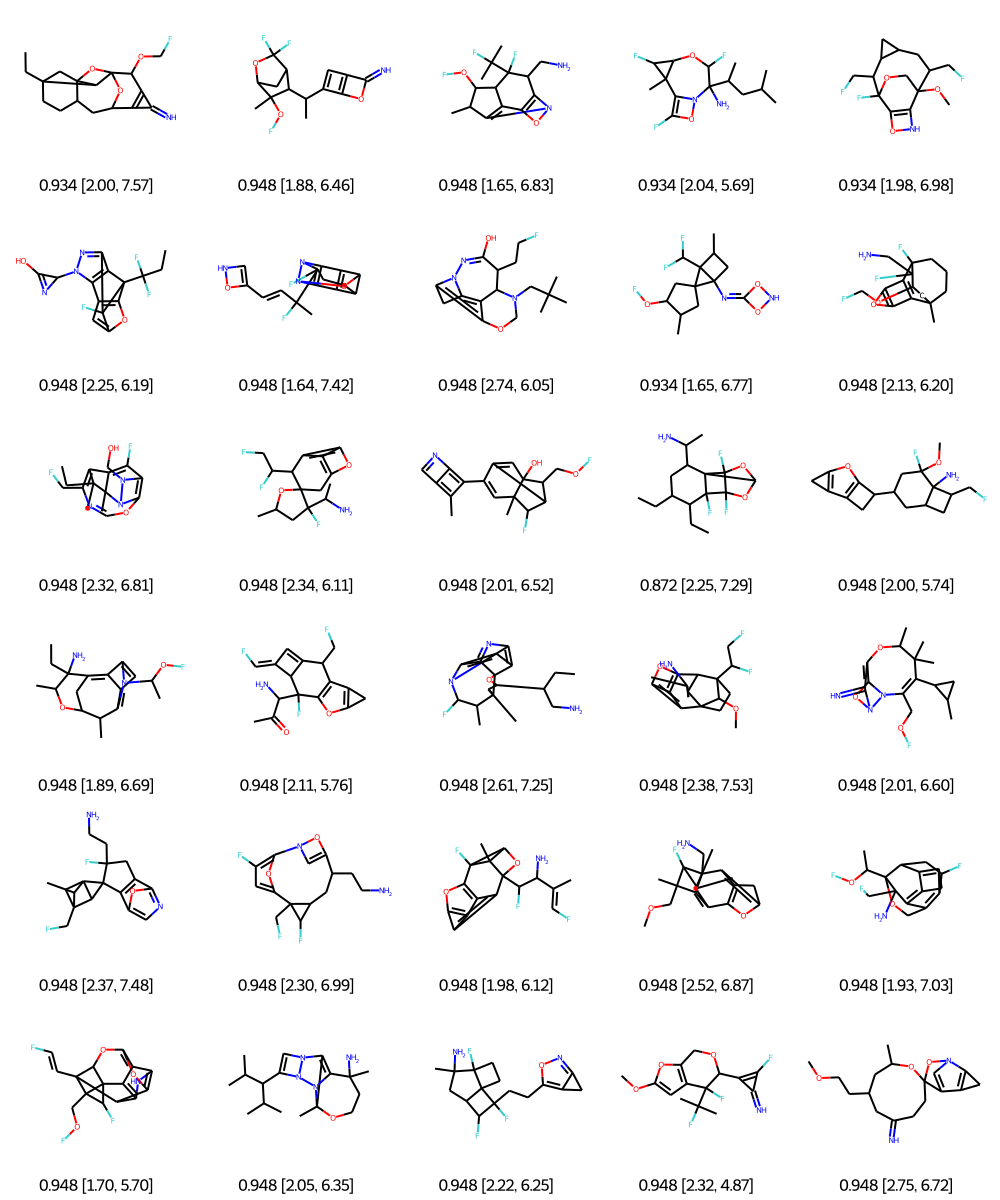

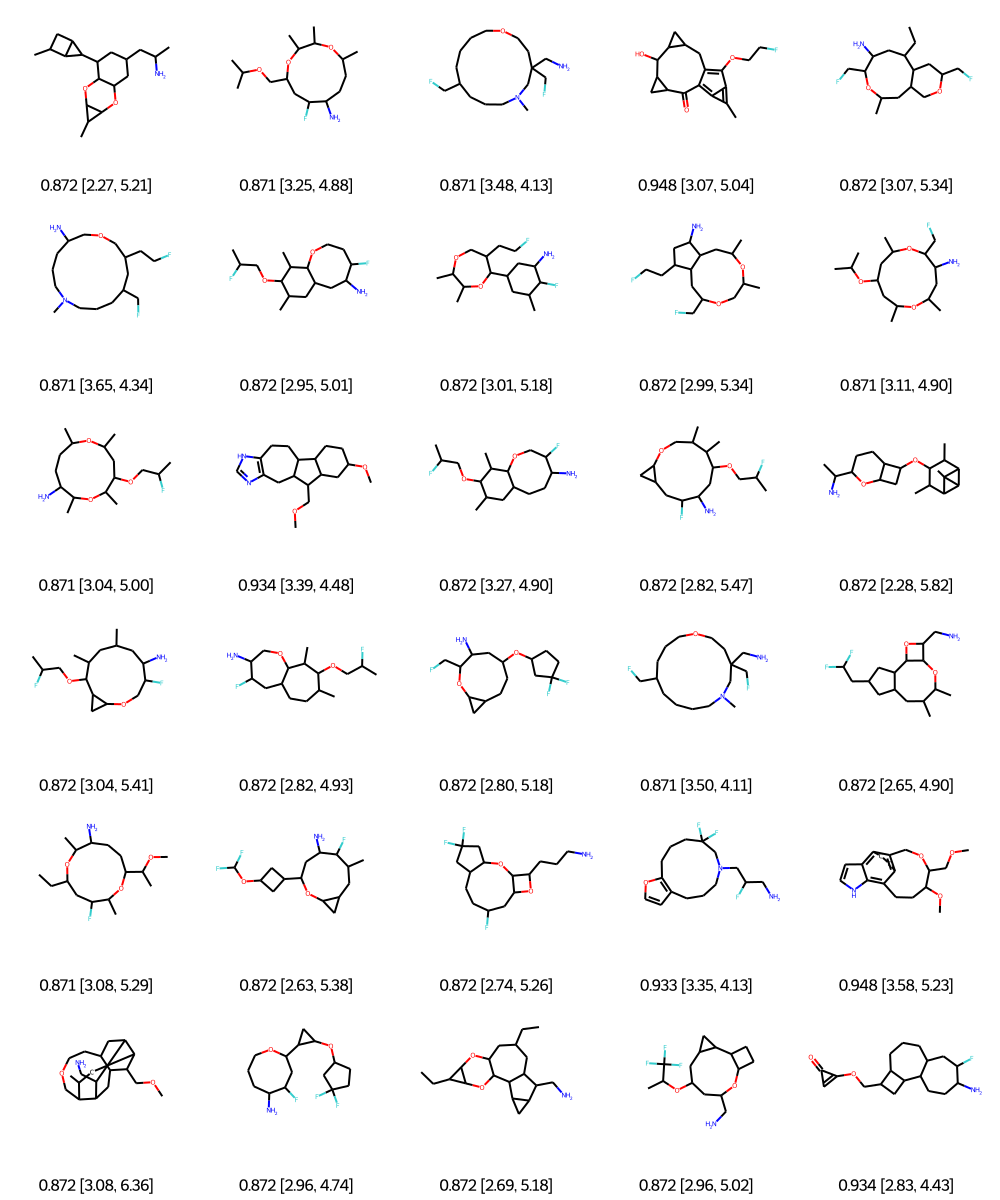

In [4]:
plot_solutions(models)